In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_parquet('flights.parquet')
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191805 entries, 0 to 1191804
Data columns (total 33 columns):
TRANSACTIONID        1191805 non-null int64
FLIGHTDATE           1191805 non-null datetime64[ns]
AIRLINECODE          1191805 non-null object
AIRLINENAME          1191805 non-null object
TAILNUM              1034988 non-null object
FLIGHTNUM            1191805 non-null int64
ORIGINAIRPORTCODE    1191805 non-null object
ORIGAIRPORTNAME      1191805 non-null object
ORIGINCITYNAME       1191805 non-null object
ORIGINSTATE          1191805 non-null object
ORIGINSTATENAME      1191805 non-null object
DESTAIRPORTCODE      1191805 non-null object
DESTAIRPORTNAME      1191805 non-null object
DESTCITYNAME         1191805 non-null object
DESTSTATE            1191805 non-null object
DESTSTATENAME        1191805 non-null object
CRSDEPTIME           1191805 non-null object
DEPTIME              1163470 non-null object
DEPDELAY             1163470 non-null float64
TAXIOUT              1011

## Questions
- Top 10 airports in terms of traffic (outgoing and incoming)
- Top 10 states in terms of traffic (outgoing and incoming)
- Top 10 airports where there is maximum delay
- Top 10 airlines in terms of departure delay
- Top 10 longest routes
- Top 3 airlines which gets cancelled a lot

### Top 10 airports
We can see below that the top 3 airports are Hartsfield-Jackson Atlanta International, Chicago O'Hare International and Dallas/Fort Worth International

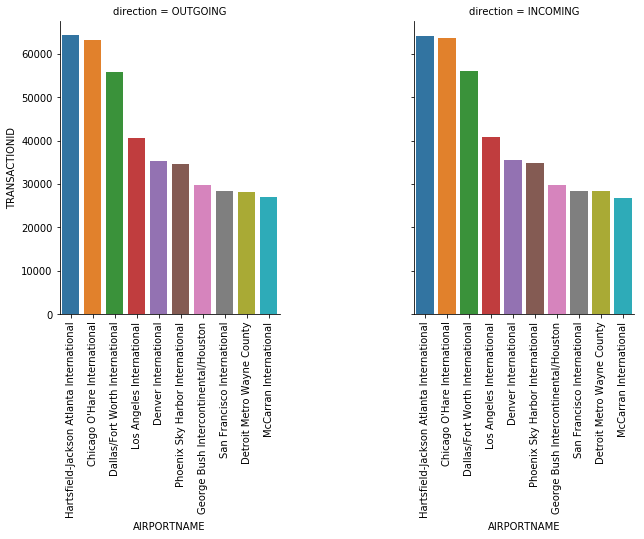

In [3]:
top10_origin_airport = flights.groupby('ORIGAIRPORTNAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_origin_airport['direction'] = 'OUTGOING'
top10_origin_airport = top10_origin_airport.rename(columns = {'ORIGAIRPORTNAME': 'AIRPORTNAME'})

top10_dest_airport = flights.groupby('DESTAIRPORTNAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_dest_airport['direction'] = 'INCOMING'
top10_dest_airport = top10_dest_airport.rename(columns = {'DESTAIRPORTNAME': 'AIRPORTNAME'})

top10_airport = top10_origin_airport.append(top10_dest_airport)
top10_airport = top10_airport.reset_index(drop=True)
# top10_airport

g = sns.catplot(x='AIRPORTNAME', y='TRANSACTIONID', data=top10_airport, col='direction', kind='bar')
g.set_xticklabels(labels=top10_airport.AIRPORTNAME, rotation=90)

### Top 10 states
We can see below that the top 3 states are California, Texas and Illinois. Both outgoing and incoming traffic are almost similar. We saw above that the second highest traffic airport was O'Hare but in terms of traffic state-wide, Texas has more traffic that Illinois. There might be other airports in Texas that count for more traffic.

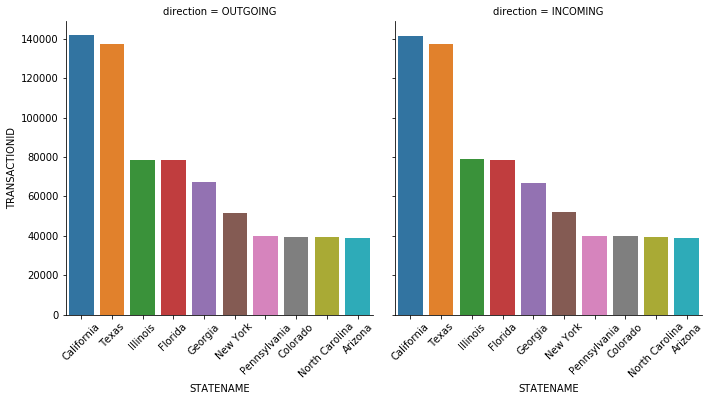

In [4]:
top10_origin_state = flights.groupby('ORIGINSTATENAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_origin_state['direction'] = 'OUTGOING'
top10_origin_state = top10_origin_state.rename(columns = {'ORIGINSTATENAME': 'STATENAME'})

top10_dest_state = flights.groupby('DESTSTATENAME', as_index=False).\
agg({'TRANSACTIONID': 'count'}).\
sort_values('TRANSACTIONID', ascending=False).head(10)
top10_dest_state['direction'] = 'INCOMING'
top10_dest_state = top10_dest_state.rename(columns = {'DESTSTATENAME': 'STATENAME'})

top10_state = top10_origin_state.append(top10_dest_state)
top10_state = top10_state.reset_index(drop=True)
# top10_state

g = sns.catplot(x='STATENAME', y='TRANSACTIONID', data=top10_state, col='direction', kind='bar')
g.set_xticklabels(labels=top10_state.STATENAME, rotation=45)

### Top 10 airports with maximum delay
We can see that although Hartsfield-Jackson Atlanta International has highest traffic, Chicago O'Hare International airport has the maximum delay

In [5]:
flights.groupby('ORIGAIRPORTNAME').agg({'DEPDELAY':'sum'}).sort_values('DEPDELAY', ascending=False).head(10)

,DEPDELAY
ORIGAIRPORTNAME,
Chicago O'Hare International,663806.0
Hartsfield-Jackson Atlanta International,538460.0
Dallas/Fort Worth International,466935.0
Denver International,297215.0
Los Angeles International,278899.0
San Francisco International,264173.0
Phoenix Sky Harbor International,249876.0
Newark Liberty International,237504.0
Detroit Metro Wayne County,221963.0


The flight data is only availabe for three months, so  we really can't do much analysis based on flight date

In [58]:
flights['FLIGHTDATE'].map(lambda x: x.month).value_counts()

5    411928
1    402156
9    377721
Name: FLIGHTDATE, dtype: int64

### Top 10 airlines causing the delay in Chicago O'Hare International Airport

In [6]:
flights[flights['ORIGAIRPORTNAME'] == "Chicago O'Hare International"].\
groupby('AIRLINENAME').\
agg({'DEPDELAY':'sum', 'TRANSACTIONID':'count'}).\
sort_values('DEPDELAY', ascending=False).\
head(10)

,DEPDELAY,TRANSACTIONID
AIRLINENAME,,
United Air Lines Inc.,247277.0,22713
American Airlines Inc.,166245.0,18062
Envoy Air,84750.0,8159
ExpressJet Airlines Inc.,34844.0,2537
SkyWest Airlines Inc.,31403.0,2860
Independence Air,18024.0,799
Delta Air Lines Inc.,16379.0,1600
Continental Air Lines Inc.,11461.0,1030
US Airways Inc.,9978.0,1378


### Number of flights per distance group
As we can see below, the distance group 300-400 miles has the maximum number of flights

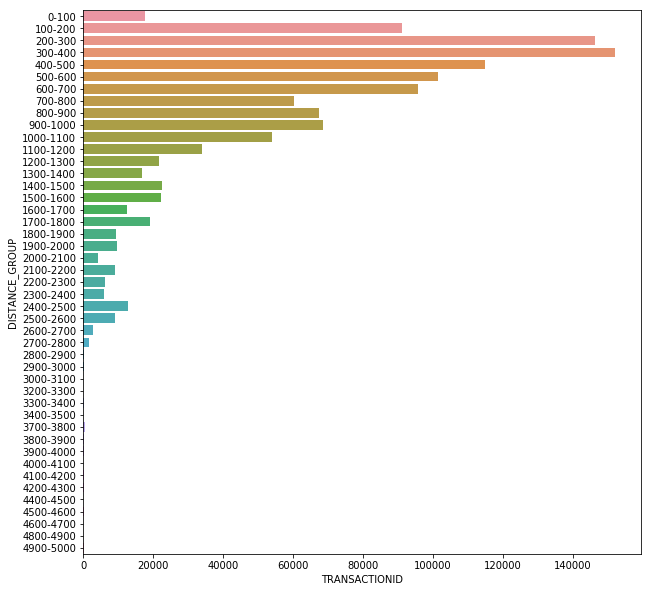

In [7]:
flights['DISTANCE_GROUP_START'] = flights['DISTANCE'].astype(int).floordiv(100)*100
distance_group = flights.groupby(['DISTANCE_GROUP', 'DISTANCE_GROUP_START'], as_index=False)\
.agg({"TRANSACTIONID": "count"})\
.sort_values("DISTANCE_GROUP_START")

plt.figure(figsize=(10, 10))
g = sns.barplot(y='DISTANCE_GROUP', x='TRANSACTIONID', data=distance_group)

### Top 3 airlines that get cancelled a lot
Although American Airlines tops the list of the most cancelled airline, that could also be because they fly a lot. So, it would be better to find the ratio of cancelled flights over total number of flights so that we get a better picture. From what we see below, Aloha Airlines has the highest ratio of cancelled flights. What's interesting to see is that Hawaiian Airlines has the lowest ratio, although they both fly in the same sector.

In [19]:
#flights[flights['CANCELLED']].groupby('AIRLINENAME').agg({"TRANSACTIONID": "count"})
flightsCancel = flights.groupby('AIRLINENAME').agg({'TRANSACTIONID':'count', 'CANCELLED':'sum'})
((flightsCancel['CANCELLED'] / flightsCancel['TRANSACTIONID']) * 100).sort_values(ascending=False)

AIRLINENAME
Aloha Airlines Inc.             4.496124
Envoy Air                       4.386767
Northwest Airlines Inc.         4.039251
Independence Air                3.652174
ExpressJet Airlines Inc.        3.285866
Comair Inc.                     3.164367
Trans World Airways LLC         3.017781
US Airways Inc.                 2.874151
United Air Lines Inc.           2.722406
American Airlines Inc.          2.592608
Alaska Airlines Inc.            2.165170
Endeavor Air Inc.               2.127396
America West Airlines Inc.      2.122323
Continental Air Lines Inc.      2.099329
SkyWest Airlines Inc.           2.055063
ExpressJet Airlines Inc. (1)    2.021023
Delta Air Lines Inc.            1.982581
Mesa Airlines Inc.              1.766993
JetBlue Airways                 1.706902
Spirit Air Lines                1.497585
Southwest Airlines Co.          1.342211
ATA Airlines d/b/a ATA          1.197183
AirTran Airways Corporation     1.166200
Virgin America                  0.586510
Fron